In [1]:
import os
import spyt
from spyt import spark_session
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit
import warnings
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import inv_boxcox
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from clan_tools.utils.spark import SPARK_CONF_MEDIUM
from clan_tools.logging.logger import default_log_config
from clan_tools.data_adapters.YTAdapter import YTAdapter


def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape, axis=0)
    return np.average(output_errors)

warnings.filterwarnings("ignore")
os.environ['NUMEXPR_MAX_THREADS'] = '32'
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 250)

In [2]:
from clan_tools.secrets.Vault import Vault
Vault().get_secrets()
yt_adapter = YTAdapter()
yt = yt_adapter.yt

spark = spyt.connect(spark_conf_args=SPARK_CONF_MEDIUM)
spyt.info(spark)

2021-12-06 15:09:44,391 - WARNING - spyt.conf - Your SPYT library has version 1.3.5 which is older than your cluster version 3.0.1-1.20.1+yandex. Some new features may not work as expected. Please update your cluster with spark-launch-yt utility
2021-12-06 15:09:57,160 - INFO - spyt.client - SPYT Cluster version: 3.0.1-1.20.1+yandex
2021-12-06 15:09:57,162 - INFO - spyt.client - SPYT library version: 1.3.5


## Loading data

In [3]:
source_path = '//home/cloud_analytics/resources_overbooking/fip4/daily_table_consumption'
calc_date = spark.read.yt(source_path).select('calc_date').agg(F.max('calc_date')).collect()[0][0]
spdf = spark.read.yt(source_path).filter(col('calc_date')==calc_date)
df = spdf.toPandas()
print(df.shape)
df.head()

(16815, 7)


,billing_account_state,billing_account_usage_status,calc_date,crm_segment,ip_count,real_consumption_vat,rep_date
0,active,paid,2021-12-06,Mass,0.068056,0.000000,2018-09-24
1,active,paid,2021-12-06,Mass,1.237836,2.629979,2018-09-25
2,active,paid,2021-12-06,Mass,1.972026,5.637889,2018-09-26
3,active,paid,2021-12-06,Mass,1.586863,4.841278,2018-09-27
4,active,paid,2021-12-06,Mass,0.979433,2.988100,2018-09-28


## General graph config

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Mass
1.77e-04 True advanced


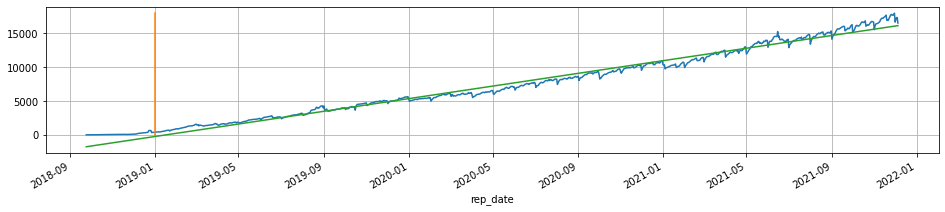

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Medium
1.35e-04 True simple


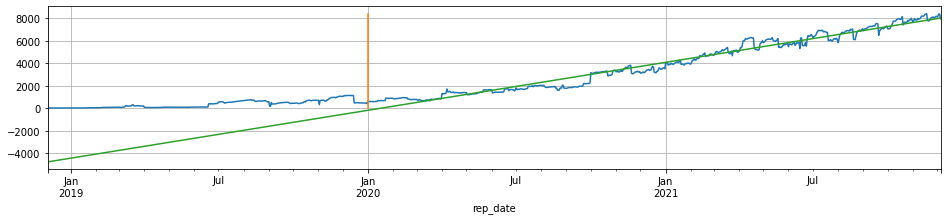

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Enterprise
6.75e-05 True advanced


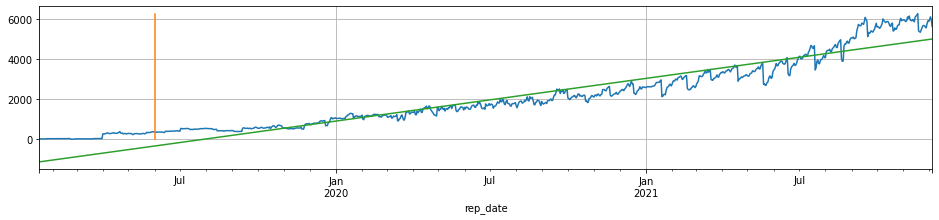

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Public sector
2.30e-05 True simple


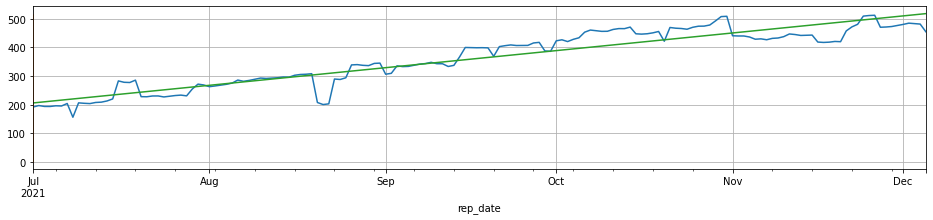

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Cloud Service
IGNORED

billing_account_state: active; billing_account_usage_status: service; crm_segment: Mass
7.34e-05 True advanced


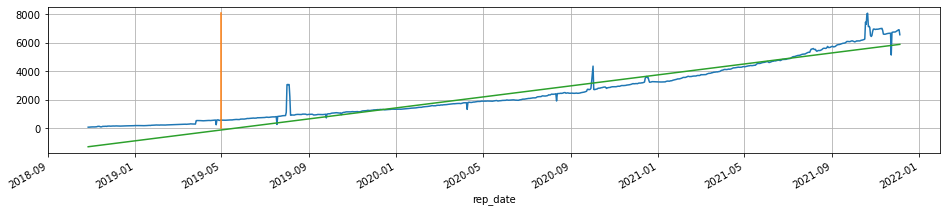

billing_account_state: active; billing_account_usage_status: service; crm_segment: Medium
IGNORED

billing_account_state: active; billing_account_usage_status: service; crm_segment: Enterprise
IGNORED

billing_account_state: active; billing_account_usage_status: service; crm_segment: Public sector
IGNORED

billing_account_state: active; billing_account_usage_status: service; crm_segment: Cloud Service
8.99e-06 False const


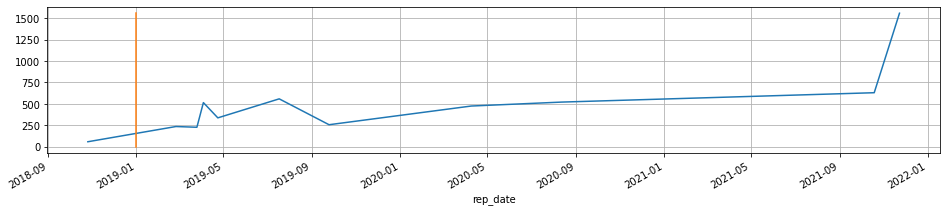

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Mass
2.89e-05 True advanced


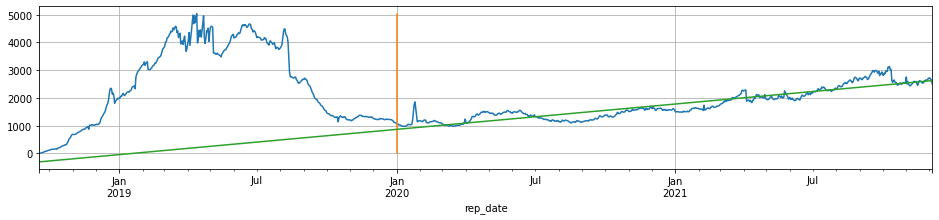

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Medium
7.72e-09 False const


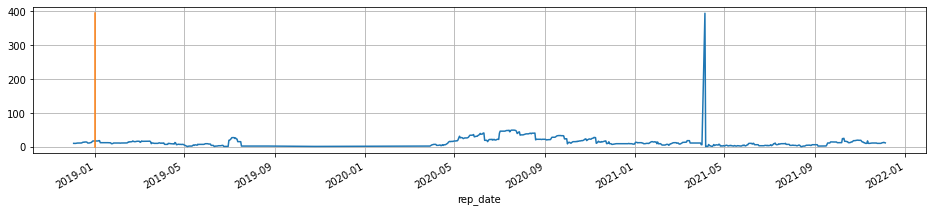

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Enterprise
1.04e-06 False simple


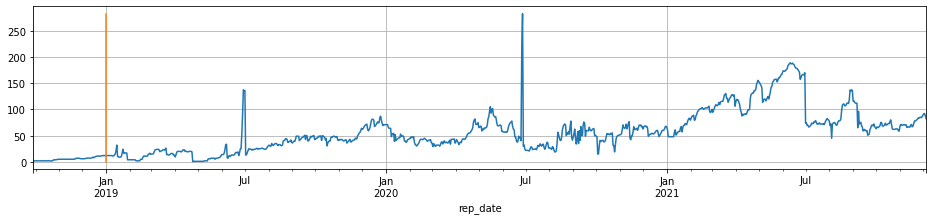

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Public sector
-5.17e-06 False const


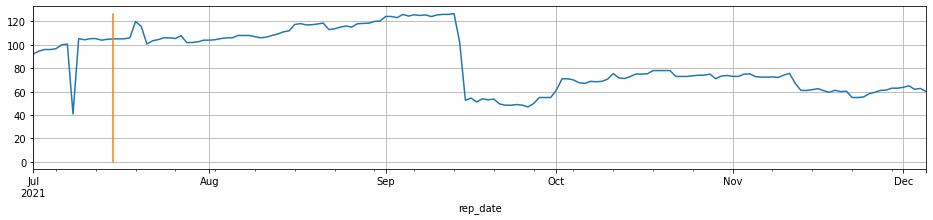

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Cloud Service
IGNORED

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Mass
-1.18e-08 False const


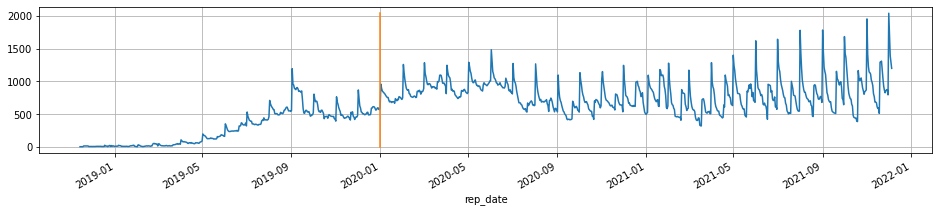

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Medium
8.66e-06 False simple


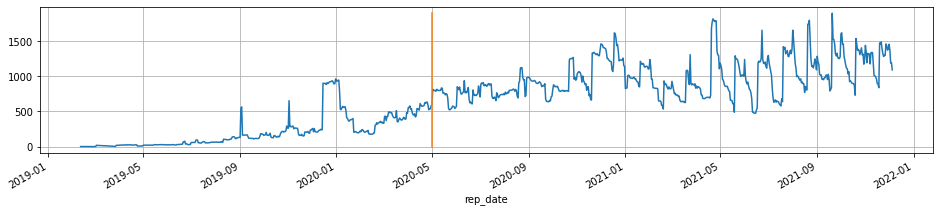

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Enterprise
2.17e-05 False simple


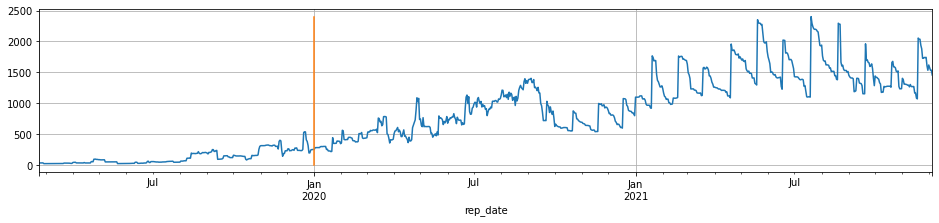

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Public sector
-4.78e-07 False const


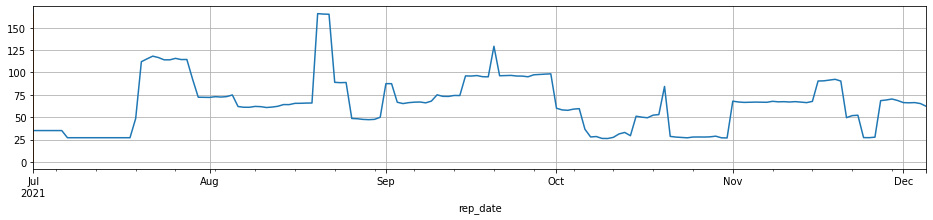

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Cloud Service
IGNORED

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Mass
-3.76e-12 False const


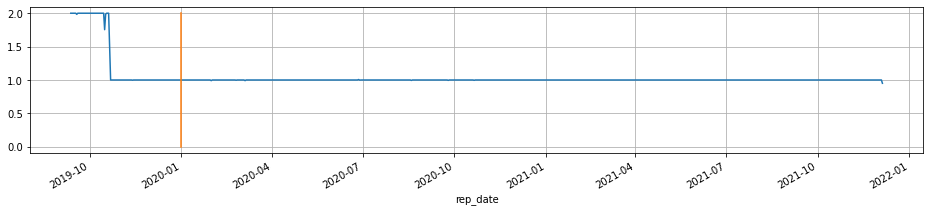

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Medium
IGNORED

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Enterprise
IGNORED

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Public sector
IGNORED

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Cloud Service
-1.55e-23 False const


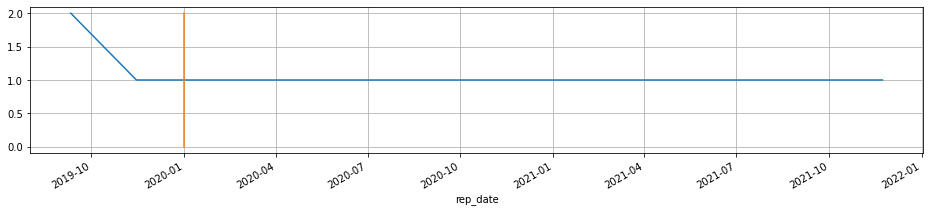

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Mass
IGNORED

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Medium
IGNORED

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Enterprise
IGNORED

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Public sector
IGNORED

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Cloud Service
IGNORED

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Mass
3.81e-06 False const


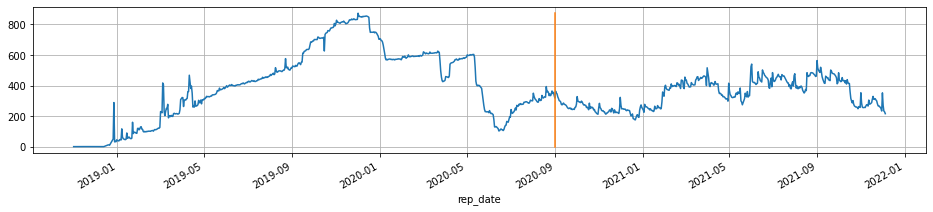

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Medium
9.86e-08 False const


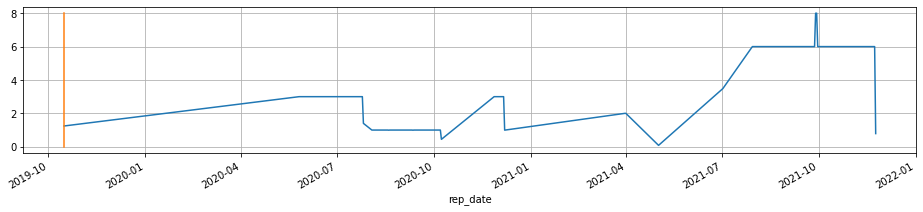

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Enterprise
-4.89e-08 False const


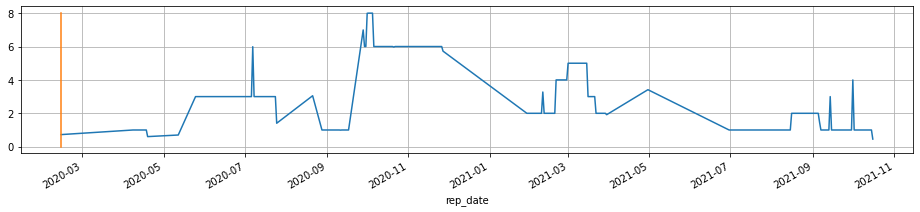

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Public sector
-4.94e-08 False const


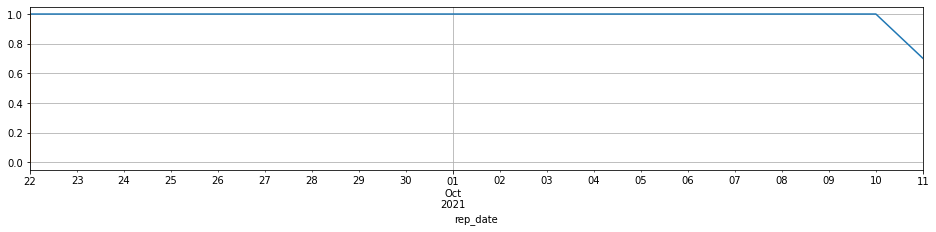

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Cloud Service
IGNORED

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Mass
1.36e-06 False const


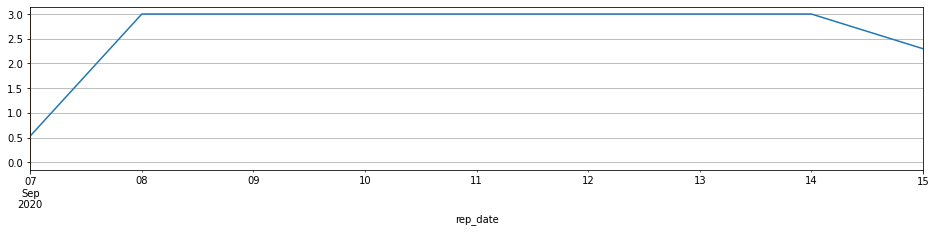

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Medium
IGNORED

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Enterprise
IGNORED

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Public sector
IGNORED

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Cloud Service
IGNORED

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Mass
9.96e-06 False const


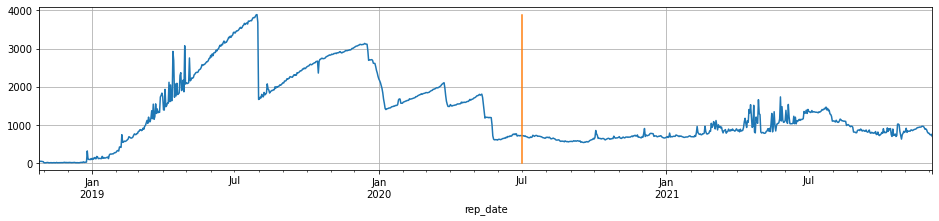

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Medium
-3.65e-09 False const


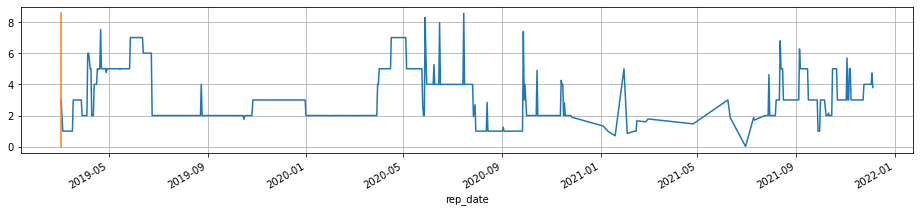

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Enterprise
1.82e-08 False const


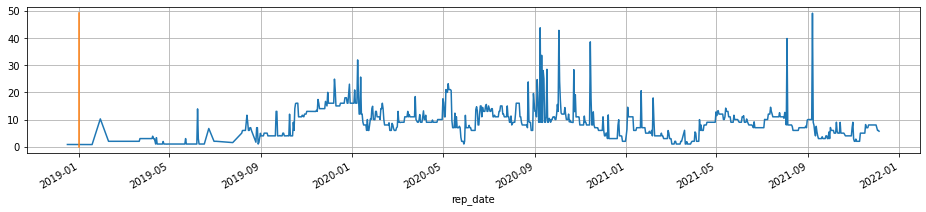

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Public sector
9.54e-09 False const


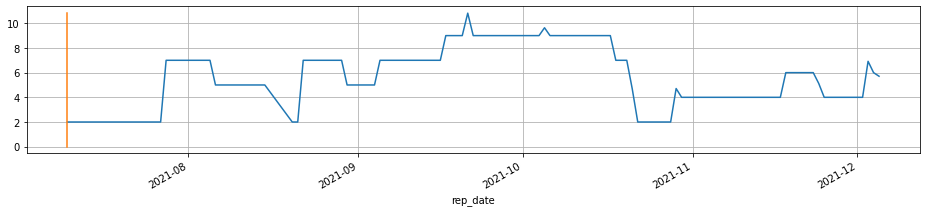

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Cloud Service
IGNORED



In [4]:
# define parameters dictionary: first key: segment, second key: state, third key: status
fip4_config = {}

# define iterator through combinations of parameters
filter_cols = ['billing_account_state', 'billing_account_usage_status', 'crm_segment']
filter_vals = {col: df[col].unique().tolist() for col in filter_cols}
filter_iterator = list(product(*[filter_vals[col] for col in filter_cols]))

# look at all possible timeseries combinations
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    print('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    
    # create params dict if not exists
    if segment not in fip4_config.keys():
        fip4_config[segment] = {}
    if state not in fip4_config[segment].keys():
        fip4_config[segment][state] = {}
    if status not in fip4_config[segment][state].keys():
        fip4_config[segment][state][status] = {}

    # general params
    fip4_config[segment][state][status]['forecast_days'] = 730
    fip4_config[segment][state][status]['history_days'] = 730
    fip4_config[segment][state][status]['date_from'] = ''

    # ignore graph and config if there is no timeseries
    if tmp_df.shape[0] < 1:
        print('IGNORED\n')
        fip4_config[segment][state][status]['forecast_type'] = 'const'
        continue
        
    # start date
    if (state == 'active') and (status == 'paid') and (segment == 'Enterprise'):
        fip4_config[segment][state][status]['date_from'] = '2019-06-01'
    elif (state == 'active') and (status == 'paid') and (segment == 'Medium'):
        fip4_config[segment][state][status]['date_from'] = '2020-01-01'
    elif (state == 'active') and (status == 'service') and (segment == 'Mass'):
        fip4_config[segment][state][status]['date_from'] = '2019-05-01'
    elif (state == 'active') and (status == 'trial') and (segment == 'Mass'):
        fip4_config[segment][state][status]['date_from'] = '2020-01-01'
    elif (state == 'payment_required') and (status == 'paid') and (segment == 'Mass'):
        fip4_config[segment][state][status]['date_from'] = '2020-01-01'
    elif (state == 'payment_required') and (status == 'paid') and (segment == 'Enterprise'):
        fip4_config[segment][state][status]['date_from'] = '2020-01-01'
    elif (state == 'suspended') and (status == 'trial') and (segment == 'Mass'):
        fip4_config[segment][state][status]['date_from'] = '2020-07-01'
    elif (state == 'payment_required') and (status == 'paid') and (segment == 'Medium'):
        fip4_config[segment][state][status]['date_from'] = '2020-05-01'
    elif (state == 'active') and (status == 'trial') and (segment == 'Public sector'):
        fip4_config[segment][state][status]['date_from'] = '2021-07-15'
    elif (state == 'payment_required') and (status == 'service') and (segment == 'Mass'):
        fip4_config[segment][state][status]['date_from'] = '2020-01-01'
    elif (state == 'payment_required') and (status == 'service') and (segment == 'Cloud Service'):
        fip4_config[segment][state][status]['date_from'] = '2020-01-01'
    elif (state == 'suspended') and (status == 'paid') and (segment == 'Mass'):
        fip4_config[segment][state][status]['date_from'] = '2020-09-01'
    else:
        fip4_config[segment][state][status]['date_from'] = max('2019-01-01', tmp_df['rep_date'].min())

    # coef
    bool_filter = tmp_df['rep_date'] >= fip4_config[segment][state][status]['date_from']
    tmp_df['rep_date'] = pd.to_datetime(tmp_df['rep_date'])
    lin_reg = LinearRegression()
    lin_reg.fit(tmp_df[['rep_date']][bool_filter].astype(int)/1e9, tmp_df['ip_count'][bool_filter])
    not_const = lin_reg.coef_[0]>1e-5 and state == 'active'
    print('%1.2e' % lin_reg.coef_[0], not_const, end=' ')

    # forecast type
    if lin_reg.coef_[0] <= 0 or tmp_df['ip_count'].max() < 100:
        fcst_type = 'const'
        fip4_config[segment][state][status]['history_days'] = 365
    elif (state == 'active') and (status == 'trial') and (segment == 'Medium'):
        fcst_type = 'const'
        fip4_config[segment][state][status]['history_days'] = 365
    elif (state == 'active') and (status == 'service') and (segment == 'Cloud Service'):
        fcst_type = 'const'
        fip4_config[segment][state][status]['history_days'] = 365
    elif (state == 'active') and (status == 'trial') and (segment == 'Public sector'):
        fcst_type = 'const'
    elif (state == 'suspended') and (status == 'paid') and (segment == 'Mass'):
        fcst_type = 'const'
        fip4_config[segment][state][status]['history_days'] = 365
    elif (state == 'suspended') and (status == 'trial') and (segment == 'Mass'):
        fcst_type = 'const'
        fip4_config[segment][state][status]['history_days'] = 365
    elif (state == 'active') and (status == 'paid') and (segment == 'Public sector'):
        fcst_type = 'simple'
        fip4_config[segment][state][status]['history_days'] = 365
    elif (state == 'active') and (status == 'paid') and (segment == 'Medium'):
        fcst_type = 'simple'
        fip4_config[segment][state][status]['history_days'] = 365
    elif not_const:
        fcst_type = 'advanced'
    else:
        fcst_type = 'simple'
    fip4_config[segment][state][status]['forecast_type'] = fcst_type
    print(fcst_type)
    
    # figure
    temp_point_y = tmp_df['ip_count'].max()
    temp_point_x = pd.to_datetime(fip4_config[segment][state][status]['date_from'])

    fig, ax = plt.subplots(figsize=(16,3))
    tmp_df = tmp_df.sort_values('rep_date')
    tmp_df = tmp_df.set_index('rep_date')
    tmp_df['ip_count'].plot(ax=ax)
    plt.plot([temp_point_x, temp_point_x], [0, temp_point_y])
    if not_const:
        plt.plot(tmp_df.index, tmp_df.index.astype(int)/1e9*lin_reg.coef_[0]+lin_reg.intercept_)
    plt.grid()
    plt.show()

# billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Mass

## Forecast for simple [Sarimax(1,1,1)] and constant cases

In [5]:
def predict_simple_and_const(df, cfg):
    # define params
    p_val = 0.01
    state = df['billing_account_state'].dropna().iloc[0]
    status = df['billing_account_usage_status'].dropna().iloc[0]
    segment = df['crm_segment'].dropna().iloc[0]
    calc_date = df['calc_date'].dropna().iloc[0]
    predict_params = cfg[segment][state][status]
    f_days = predict_params['forecast_days']
    h_days = predict_params['history_days']
    if predict_params['date_from'] == '':
        dt_from = df['rep_date'].min()
    else:
        dt_from = predict_params['date_from']

    # make normal timeseries
    ts_df = df[df['rep_date']>=dt_from].sort_values(by='rep_date')
    new_index = pd.to_datetime(ts_df['rep_date'])
    ts_df = ts_df.set_index(new_index.values)
    ts = ts_df['ip_count'].iloc[-h_days:]

    # prediction date borders
    dt_fmt = '%Y-%m-%d'
    from_date = datetime.strptime(df['rep_date'].max(), dt_fmt) + timedelta(days=1)
    to_date = datetime.strptime(df['rep_date'].max(), dt_fmt) + timedelta(days=f_days)

    # predict const graph
    if predict_params['forecast_type'] == 'const':
        mean = int(round(ts.median()))
        mean_se = round(ts.std(), 2)
        mean_ci_lower = max(int(round(ts.quantile(q=p_val*0.5)-1)), 0)
        mean_ci_upper = int(round(ts.quantile(q=1-p_val*0.5)+1))

        df_pred = pd.DataFrame(index=pd.date_range(from_date, to_date))
        df_pred['mean'] = mean
        df_pred['mean_se'] = mean_se
        df_pred['mean_ci_lower'] = mean_ci_lower
        df_pred['mean_ci_upper'] = mean_ci_upper
        result_df = pd.concat([ts.rename('ip_count'), df_pred], axis=1)

    # forward fill ts for stasmodels library
    ts = ts.resample('D').max().ffill()
    
    # predict simple graph
    if predict_params['forecast_type'] == 'simple':
        simple_model = sm.tsa.SARIMAX(ts, order=(1, 1, 1), trend='t').fit(maxiter=200)
        try:
            df_pred = simple_model.get_forecast(to_date).summary_frame().clip(lower=0)
            df_pred['rep_date'] = df_pred.index.strftime(dt_fmt)
            result_df = pd.concat([ts.rename('ip_count'), df_pred], axis=1)
        except Exception:
            result_df = pd.DataFrame(ts.rename('ip_count'))
            result_df['mean'] = np.nan
            result_df['mean_se'] = np.nan
            result_df['mean_ci_lower'] = np.nan
            result_df['mean_ci_upper'] = np.nan
        result_df['rep_date'] = result_df.index.strftime(dt_fmt)

    result_df['rep_date'] = result_df.index.strftime(dt_fmt)
    result_df = result_df.reset_index(drop=True)
    result_df['calc_date'] = calc_date
    result_df['billing_account_state'] = state
    result_df['billing_account_usage_status'] = status
    result_df['crm_segment'] = segment
        
    return result_df

# simple and const forecasts at all possible timeseries combinations
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    print('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type == 'advanced'):
        print(graph_type, 'IGNORED\n')
        continue
    
    print(graph_type)

    tmp_df = predict_simple_and_const(tmp_df, fip4_config)
    break
    # figure
    fig, ax = plt.subplots(figsize=(16,3))
    tmp_df = tmp_df.sort_values('rep_date')
    tmp_df['rep_date'] = pd.to_datetime(tmp_df['rep_date'])
    tmp_df = tmp_df.set_index('rep_date')
    tmp_df['ip_count'].plot(ax=ax)
    tmp_df['mean'].plot(ax=ax, c='green')
    tmp_df['mean_ci_lower'].plot(ax=ax, c='orange')
    tmp_df['mean_ci_upper'].plot(ax=ax, c='orange')
    plt.grid()
    plt.xlim(tmp_df.index.min(), tmp_df.index.max())
    plt.show()
    

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Mass
advanced IGNORED

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Medium
simple


In [6]:
tmp_df

,ip_count,mean,mean_se,mean_ci_lower,mean_ci_upper,rep_date,calc_date,billing_account_state,billing_account_usage_status,crm_segment
0,3159.476192,NaN,NaN,NaN,NaN,2020-12-06,2021-12-06,active,paid,Medium
1,3250.737350,NaN,NaN,NaN,NaN,2020-12-07,2021-12-06,active,paid,Medium
2,3331.533530,NaN,NaN,NaN,NaN,2020-12-08,2021-12-06,active,paid,Medium
3,3384.838449,NaN,NaN,NaN,NaN,2020-12-09,2021-12-06,active,paid,Medium
4,3411.681100,NaN,NaN,NaN,NaN,2020-12-10,2021-12-06,active,paid,Medium
...,...,...,...,...,...,...,...,...,...,...
1090,NaN,35162.651393,1938.739784,31362.791242,38962.511544,2023-12-01,2021-12-06,active,paid,Medium
1091,NaN,35218.474685,1940.030081,31416.085598,39020.863772,2023-12-02,2021-12-06,active,paid,Medium
1092,NaN,35274.349362,1941.319520,31469.433020,39079.265704,2023-12-03,2021-12-06,active,paid,Medium
1093,NaN,35330.275423,1942.608104,31522.833503,39137.717342,2023-12-04,2021-12-06,active,paid,Medium


## Forecast for advanced cases - Sarimax

### Timeseries decomposition

In [7]:
# decomposition function
def plotseasonal_partial(res, axes, plot_label=False):
    def inner_plot(num, series, name, plot_xticks=False, plot_ylabel=plot_label,):
        axes[num].plot(series.index, series)
        if plot_ylabel:
            axes[num].set_ylabel(name)
        axes[num].set_yticks([])
        if not plot_xticks:
            axes[num].set_xticks([])
        else:
            axes[num].tick_params(axis='x', rotation=45, labelsize=8)
            
    inner_plot(0, res.observed, 'Observed')
    inner_plot(1, res.trend, 'Trend')
    inner_plot(2, res.seasonal, 'Seasonal')
    inner_plot(3, res.resid, 'Residual', True)

    for ax in axes:
        fig.add_subplot(ax)

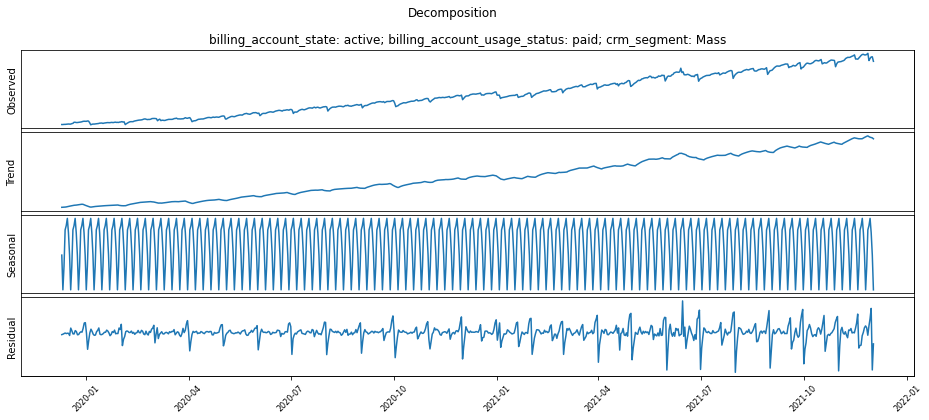

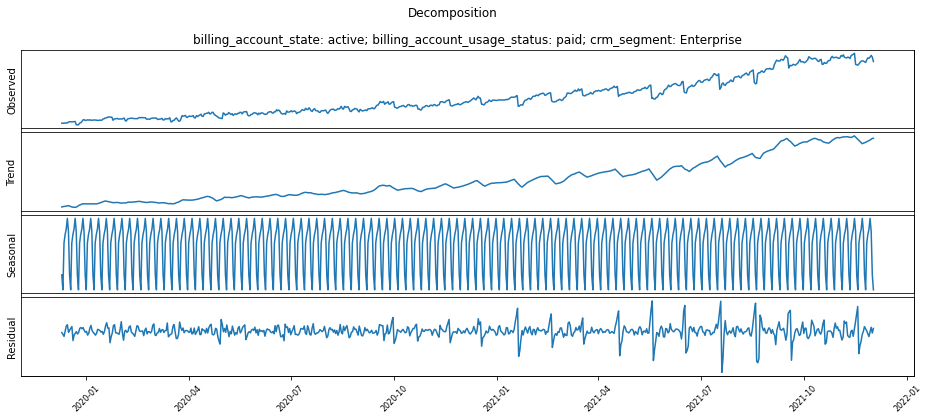

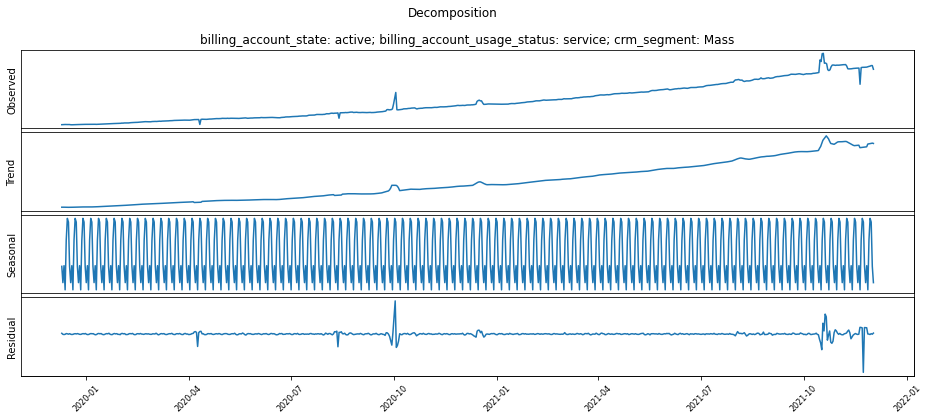

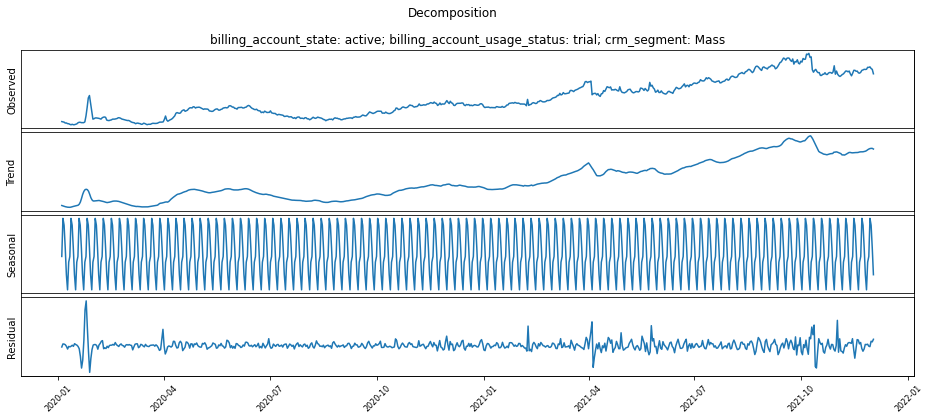

In [8]:
# decomposition at all possible timeseries combinations
all_dts = {}
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    n_days = fip4_config[segment][state][status]['history_days']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    # create datasets dict if not exists
    if segment not in all_dts.keys():
        all_dts[segment] = {}
    if state not in all_dts[segment].keys():
        all_dts[segment][state] = {}
    if status not in all_dts[segment][state].keys():
        all_dts[segment][state][status] = {}

    # figure
    fig = plt.figure(figsize=(16, 6))
    plt.suptitle(f'Decomposition')
    outer = gridspec.GridSpec(nrows=1, ncols=1, wspace=0.1, hspace=0.25)
    fig.add_subplot(outer[0])

    tmp_df = tmp_df[tmp_df['rep_date']>=date_from]
    tmp_df['rep_date'] = pd.to_datetime(tmp_df['rep_date'])
    dts_temp = tmp_df.set_index('rep_date')[['ip_count']].resample('D').max().ffill().iloc[-n_days:]
    
    all_dts[segment][state][status].update({'general': dts_temp})
    plt.title('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    plt.xticks([])
    plt.yticks([])
    inner = gridspec.GridSpecFromSubplotSpec(
        subplot_spec=outer[0],
        nrows=4, ncols=1,
        wspace=0.05, hspace=0.05
    )
    try:
        res = sm.tsa.seasonal_decompose(dts_temp[['ip_count']])
        axes = [plt.Subplot(fig, inner[k]) for k in range(4)]
        plotseasonal_partial(res, axes, True)
    except ValueError:
        pass
    plt.show()

### Data split

In [9]:
# data split at all possible timeseries combinations
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    print('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))

    general = all_dts[segment][state][status]['general']
    
    train = general[:-max(90, len(general)*3//10)]
    valid = general[-max(90, len(general)*3//10):]
    crit_df = sm.tsa.stattools.adfuller(general)[1]
    all_dts[segment][state][status].update({
        'train'  : train, 
        'valid'  : valid, 
        'params' : {'DF-test': crit_df}
    })
    print('Adfuller: %.3f' % crit_df)

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Mass
Adfuller: 0.994
billing_account_state: active; billing_account_usage_status: paid; crm_segment: Enterprise
Adfuller: 0.992
billing_account_state: active; billing_account_usage_status: service; crm_segment: Mass
Adfuller: 0.996
billing_account_state: active; billing_account_usage_status: trial; crm_segment: Mass
Adfuller: 0.769


### Variance stabilization attempt

In [10]:
target_col = 'ip_count'
def add_boxcox_ts(df, lmbda, col=target_col):
    df = df.copy()
    df[col+'_box'] = stats.boxcox(df[col], lmbda=lmbda)
    return df

# data split at all possible timeseries combinations
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    print('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    
    _, lmbda = stats.boxcox(all_dts[segment][state][status]['train'][target_col])
    lmbda = min(max(lmbda,-5),5)
    all_dts[segment][state][status]['general'] = add_boxcox_ts(
        all_dts[segment][state][status]['general'], lmbda
    )
    all_dts[segment][state][status]['train'] = add_boxcox_ts(
        all_dts[segment][state][status]['train'], lmbda
    )
    all_dts[segment][state][status]['valid'] = add_boxcox_ts(
        all_dts[segment][state][status]['valid'], lmbda
    )

    all_dts[segment][state][status]['params']['boxcox'] = lmbda
    crit_df = sm.tsa.stattools.adfuller(all_dts[segment][state][status]['general'][target_col+'_box'])[1]
    all_dts[segment][state][status]['params']['DF-test_box'] = crit_df

    print('Boxcox: %.3f; Adfuller: %.3f' % (lmbda, crit_df))

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Mass
Boxcox: 0.322; Adfuller: 0.895
billing_account_state: active; billing_account_usage_status: paid; crm_segment: Enterprise
Boxcox: 0.324; Adfuller: 0.921
billing_account_state: active; billing_account_usage_status: service; crm_segment: Mass
Boxcox: 0.123; Adfuller: 0.898
billing_account_state: active; billing_account_usage_status: trial; crm_segment: Mass
Boxcox: -0.348; Adfuller: 0.620


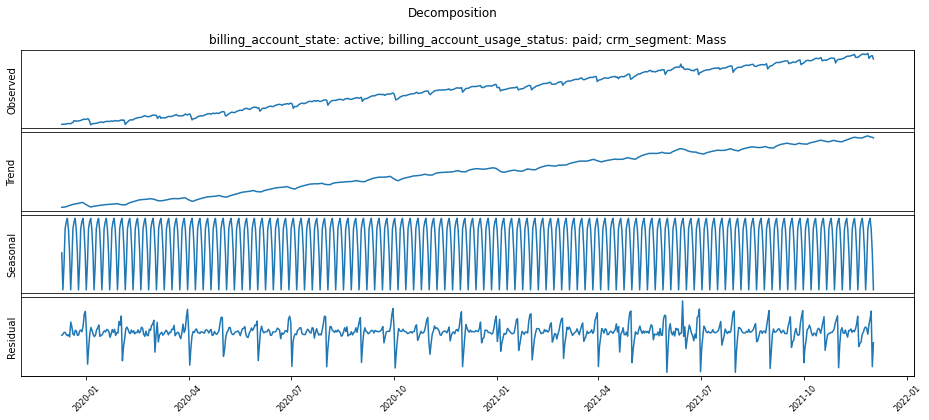

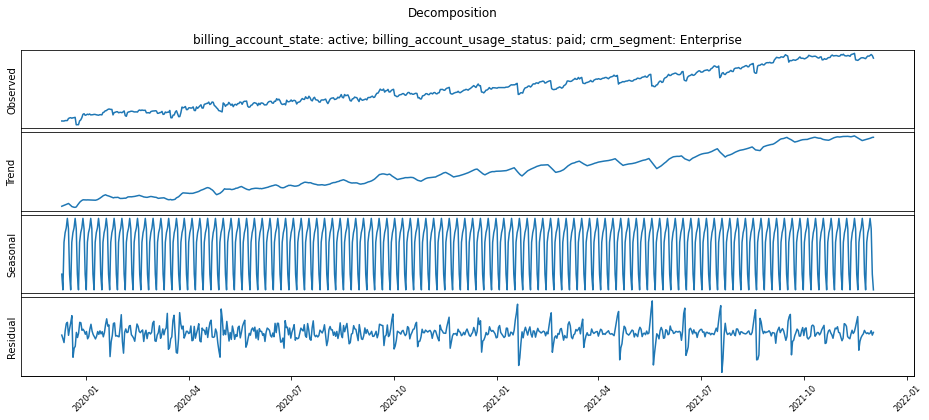

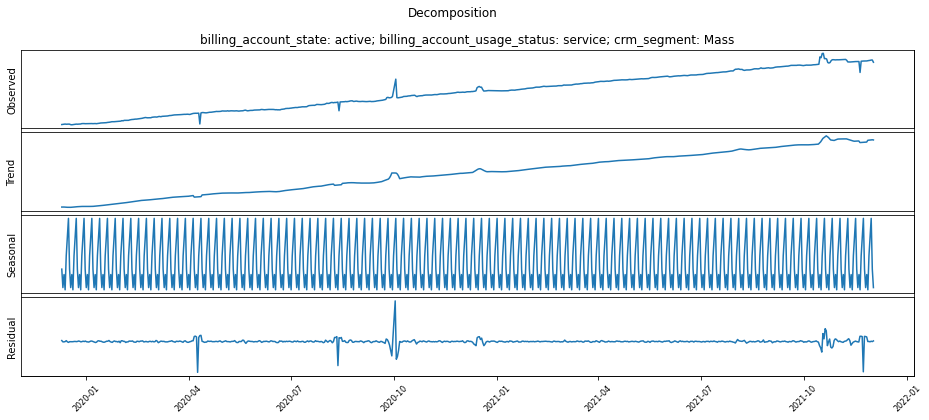

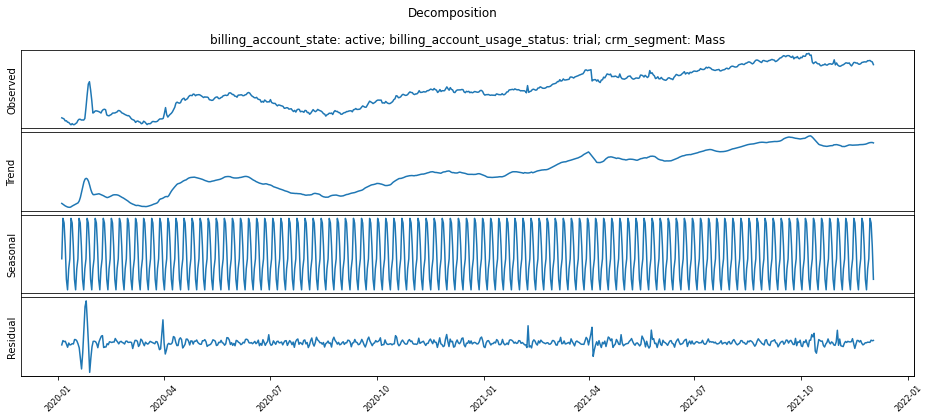

In [11]:
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    # figure
    fig = plt.figure(figsize=(16, 6))
    plt.suptitle(f'Decomposition')
    outer = gridspec.GridSpec(nrows=1, ncols=1, wspace=0.1, hspace=0.25)
    fig.add_subplot(outer[0])

    dts_temp = all_dts[segment][state][status]['general']
    
    plt.title('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    plt.xticks([])
    plt.yticks([])
    inner = gridspec.GridSpecFromSubplotSpec(
        subplot_spec=outer[0],
        nrows=4, ncols=1,
        wspace=0.05, hspace=0.05
    )
    try:
        res = sm.tsa.seasonal_decompose(dts_temp[[target_col+'_box']])
        axes = [plt.Subplot(fig, inner[k]) for k in range(4)]
        plotseasonal_partial(res, axes, True)
    except ValueError:
        pass
    plt.show()

### Stationarity

In [12]:
season_comp = True
col_to_work = target_col # + '_box'
col_to_work2 = col_to_work + '_sdiff'

def add_season_diff_ts(df, col=col_to_work, S=7):
    df = df.copy()
    if season_comp:
        df[col_to_work2] = df[col_to_work].diff(S)
    else:
        df[col_to_work2] = df[col_to_work]
    return df

for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    print('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    
    all_dts[segment][state][status]['general'] = add_season_diff_ts(all_dts[segment][state][status]['general'])
    all_dts[segment][state][status]['train'] = add_season_diff_ts(all_dts[segment][state][status]['train'])
    all_dts[segment][state][status]['valid'] = add_season_diff_ts(all_dts[segment][state][status]['valid'])
    all_dts[segment][state][status]['params']['S'] = 7 if season_comp else 0
    all_dts[segment][state][status]['params']['D'] = 1 if season_comp else 0
    crit_df = sm.tsa.stattools.adfuller(all_dts[segment][state][status]
                                        ['general'][col_to_work2].dropna())[1]
    all_dts[segment][state][status]['params'].update({'DF-test_sdiff': crit_df, 'work_col': col_to_work})
    
    print('Adfuller: %.2e' % crit_df)

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Mass
Adfuller: 1.65e-19
billing_account_state: active; billing_account_usage_status: paid; crm_segment: Enterprise
Adfuller: 3.97e-19
billing_account_state: active; billing_account_usage_status: service; crm_segment: Mass
Adfuller: 6.91e-11
billing_account_state: active; billing_account_usage_status: trial; crm_segment: Mass
Adfuller: 8.52e-08


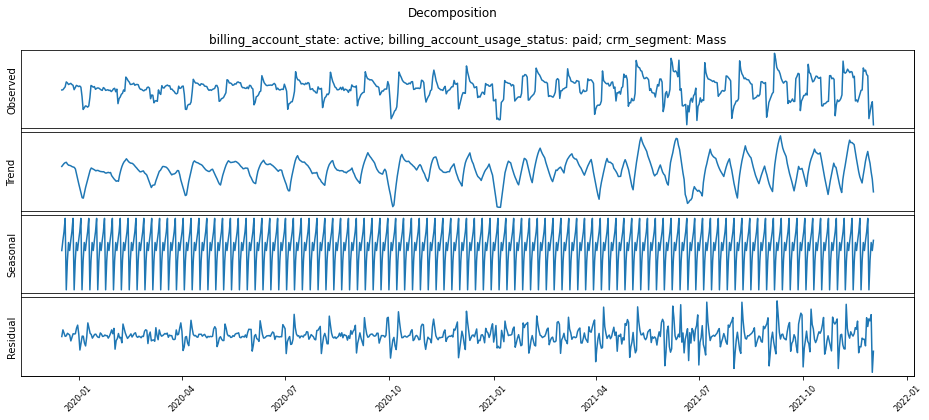

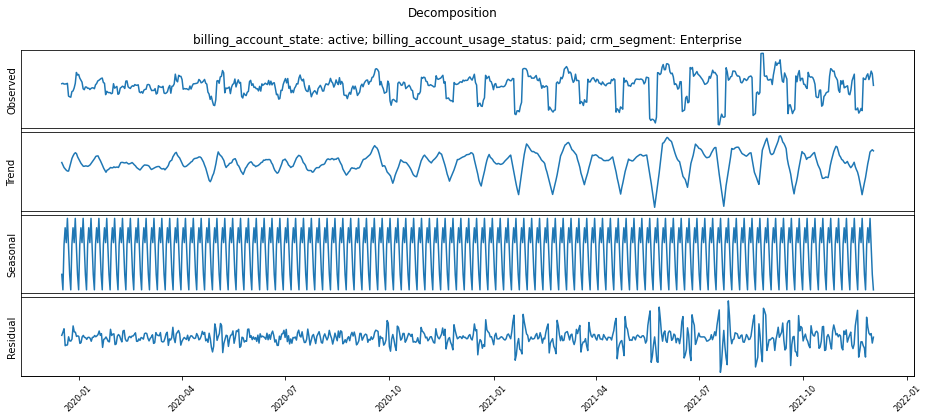

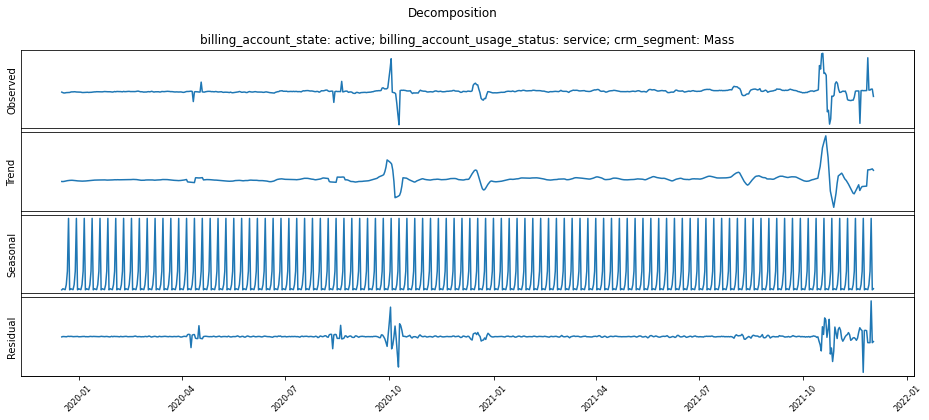

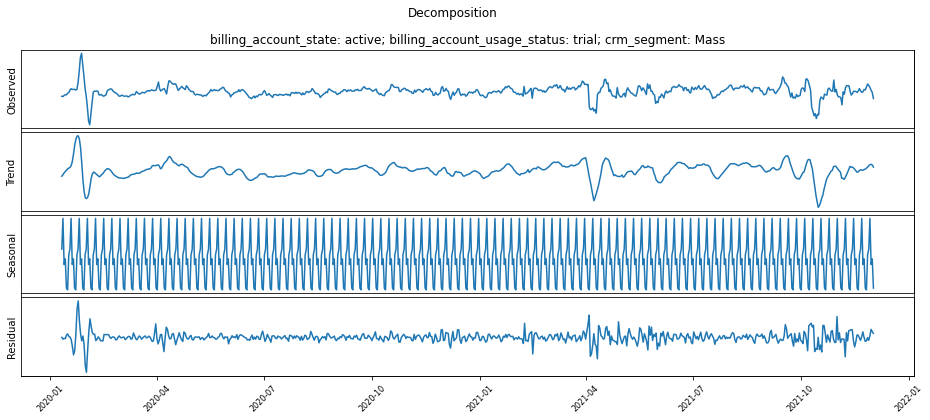

In [13]:
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    # figure
    fig = plt.figure(figsize=(16, 6))
    plt.suptitle(f'Decomposition')
    outer = gridspec.GridSpec(nrows=1, ncols=1, wspace=0.1, hspace=0.25)
    fig.add_subplot(outer[0])

    dts_temp = all_dts[segment][state][status]['general']
    
    plt.title('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    plt.xticks([])
    plt.yticks([])
    inner = gridspec.GridSpecFromSubplotSpec(
        subplot_spec=outer[0],
        nrows=4, ncols=1,
        wspace=0.05, hspace=0.05
    )
    try:
        res = sm.tsa.seasonal_decompose(dts_temp[[col_to_work+'_sdiff']].dropna())
        axes = [plt.Subplot(fig, inner[k]) for k in range(4)]
        plotseasonal_partial(res, axes, True)
    except ValueError:
        pass
    plt.show()

In [14]:
col_to_work3 = col_to_work2.replace('_sdiff','') + '_diff'

def add_simple_diff_ts(df):
    df[col_to_work3] = df[col_to_work2].diff()
    return df

for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    print('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    
    all_dts[segment][state][status]['general'] = add_simple_diff_ts(all_dts[segment][state][status]['general'])
    all_dts[segment][state][status]['train'] = add_simple_diff_ts(all_dts[segment][state][status]['train'])
    all_dts[segment][state][status]['valid'] = add_simple_diff_ts(all_dts[segment][state][status]['valid'])
    all_dts[segment][state][status]['params']['d'] = 1
    crit_df = sm.tsa.stattools.adfuller(
        all_dts[segment][state][status]['general'][col_to_work3].dropna()
    )[1]
    all_dts[segment][state][status]['params'].update({'DF-test_diff': crit_df})
    
    print('Adfuller: %.2e' % crit_df)

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Mass
Adfuller: 7.82e-12
billing_account_state: active; billing_account_usage_status: paid; crm_segment: Enterprise
Adfuller: 5.78e-18
billing_account_state: active; billing_account_usage_status: service; crm_segment: Mass
Adfuller: 2.55e-19
billing_account_state: active; billing_account_usage_status: trial; crm_segment: Mass
Adfuller: 8.20e-19


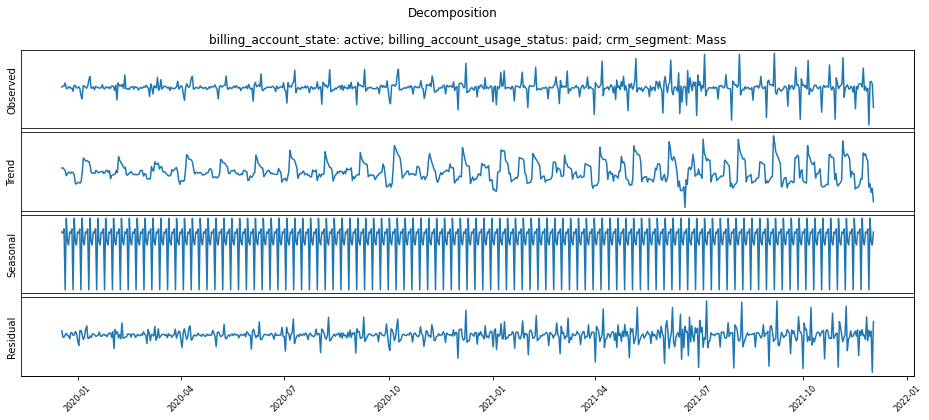

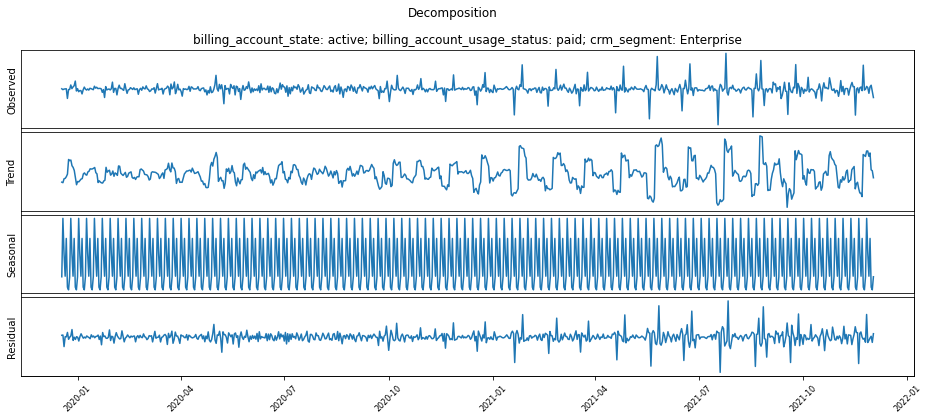

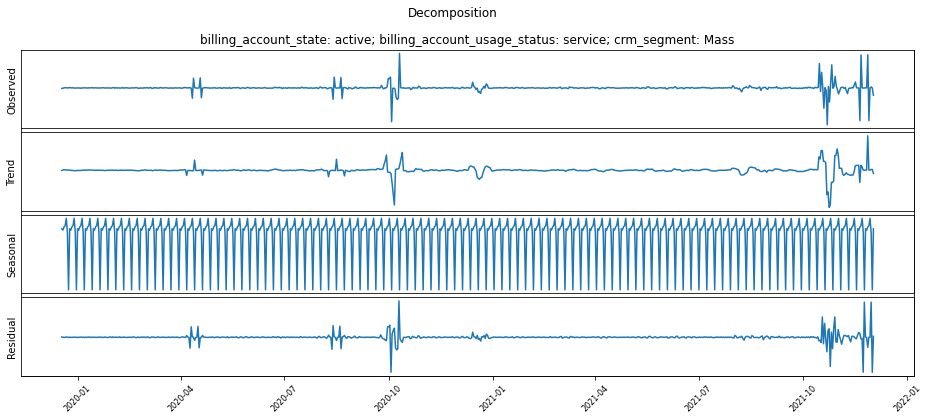

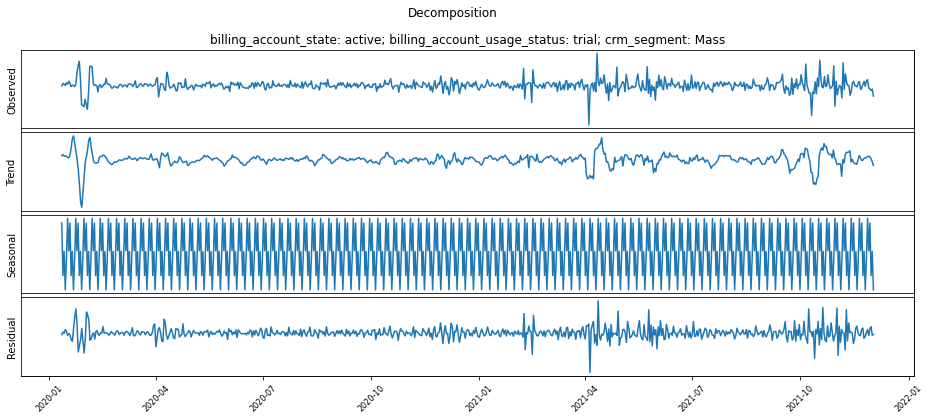

In [15]:
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    # figure
    fig = plt.figure(figsize=(16, 6))
    plt.suptitle(f'Decomposition')
    outer = gridspec.GridSpec(nrows=1, ncols=1, wspace=0.1, hspace=0.25)
    fig.add_subplot(outer[0])

    dts_temp = all_dts[segment][state][status]['general']
    
    plt.title('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    plt.xticks([])
    plt.yticks([])
    inner = gridspec.GridSpecFromSubplotSpec(
        subplot_spec=outer[0],
        nrows=4, ncols=1,
        wspace=0.05, hspace=0.05
    )
    try:
        res = sm.tsa.seasonal_decompose(dts_temp[[col_to_work3]].dropna())
        axes = [plt.Subplot(fig, inner[k]) for k in range(4)]
        plotseasonal_partial(res, axes, True)
    except ValueError:
        pass
    plt.show()

### Search of hyperparameters

In [16]:
# universal parameters list
ps = np.arange(4)
qs = np.arange(4)
Ps = np.array([0])
Qs = np.array([0])
Ss = np.array([0])
trs = np.array(['c','t'])
parameters_0 = product(ps, qs, Ps, Qs, Ss, trs)

ps = np.arange(4)
qs = np.arange(3)
Ps = np.arange(2)
Qs = np.arange(2)
Ss = np.array([7])
trs = np.array(['c','t'])
parameters_7 = product(ps, qs, Ps, Qs, Ss, trs)


parameters_list = list(parameters_0)+list(parameters_7)
len(parameters_list)

128

In [17]:
decision_metric = 'AIC'

warnings.filterwarnings('ignore')
def sarimax_fit(segment, state, status, parameters_list, verbose=False, decision_metric=decision_metric):
    
    dts_train = all_dts[segment][state][status]['train'][col_to_work].dropna().resample('D').max().ffill()
    dts_valid = all_dts[segment][state][status]['valid'][col_to_work].dropna().resample('D').max().ffill()
    
    results = []
    for param in tqdm(parameters_list, postfix='Work on: [%s]' % '; '.join([segment, state, status])):
        # training
        try:
            model=sm.tsa.statespace.SARIMAX(dts_train, 
                                            order=(param[0], # p
                                                   all_dts[segment][state][status]['params']['d'], # d
                                                   param[1]), # q
                                            seasonal_order=(param[2], # P
                                                            int(param[4] != 0), # D
                                                            param[3], # Q
                                                            param[4]), # S
                                            trend=param[5]).fit(disp=-1)
            assert all(model.predict().notna())
        except Exception:
            if verbose:
                print('Error!\tWrong parameters:', param)
            continue

        # logging resulta
        try:
            aic = model.aic # The Akaike information criterion
            mse_train = model.mse # mse train
            mae_train = model.mae # mae train
            mape_train = mean_absolute_percentage_error(dts_train, model.predict()) # mape train
            R2_train = r2_score(dts_train, model.predict()) # R_squared train
            forecast_valid = model.get_forecast(dts_valid.index[-1]).summary_frame().loc[dts_valid.index]
            mse_valid = mean_squared_error(dts_valid, forecast_valid['mean']) # mse valid
            mae_valid = mean_absolute_error(dts_valid, forecast_valid['mean']) # mae valid
            mape_valid = mean_absolute_percentage_error(dts_valid, forecast_valid['mean']) # mape valid
            R2_valid = r2_score(dts_valid, forecast_valid['mean']) # R_squared valid

            results.append([param, aic, 
                            mse_train, mae_train, mape_train, R2_train, 
                            mse_valid, mae_valid, mape_valid, R2_valid, 
                           ])
        except:
            print('New type Error:', param)
            continue

    cols = [
        'params', 'AIC', 'mse_train', 'mae_train', 'mape_train', 'R2_train', 
        'mse_valid', 'mae_valid', 'mape_valid', 'R2_valid', 
    ]
    results = pd.DataFrame(results, columns=cols)
    all_dts[segment][state][status]['results'] = results
    to_save = dict(results.loc[results[decision_metric].idxmin()])
    all_dts[segment][state][status]['params']['p'] = int(to_save['params'][0])
    all_dts[segment][state][status]['params']['q'] = int(to_save['params'][1])
    all_dts[segment][state][status]['params']['P'] = int(to_save['params'][2])
    all_dts[segment][state][status]['params']['Q'] = int(to_save['params'][3])
    all_dts[segment][state][status]['params']['D'] = int(to_save['params'][4] != 0)
    all_dts[segment][state][status]['params']['S'] = int(to_save['params'][4])
    all_dts[segment][state][status]['params']['trend'] = to_save['params'][5]
    best_model = sm.tsa.statespace.SARIMAX(dts_train, 
                                           order=(all_dts[segment][state][status]['params']['p'], # p
                                                  all_dts[segment][state][status]['params']['d'], # d
                                                  all_dts[segment][state][status]['params']['q']), # q
                                           seasonal_order=(all_dts[segment][state][status]['params']['P'], # P
                                                           all_dts[segment][state][status]['params']['D'], # D
                                                           all_dts[segment][state][status]['params']['Q'], # Q
                                                           all_dts[segment][state][status]['params']['S']), # S
                                           trend=all_dts[segment][state][status]['params']['trend']).fit(disp=-1)
    all_dts[segment][state][status]['best_model'] = best_model

for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    sarimax_fit(segment, state, status, parameters_list, verbose=True)


  0%|          | 0/128 [00:00<?, ?it/s, Work on: [Mass; active; paid]]

  0%|          | 0/128 [00:00<?, ?it/s, Work on: [Enterprise; active; paid]]

  0%|          | 0/128 [00:00<?, ?it/s, Work on: [Mass; active; service]]

  0%|          | 0/128 [00:00<?, ?it/s, Work on: [Mass; active; trial]]

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Mass


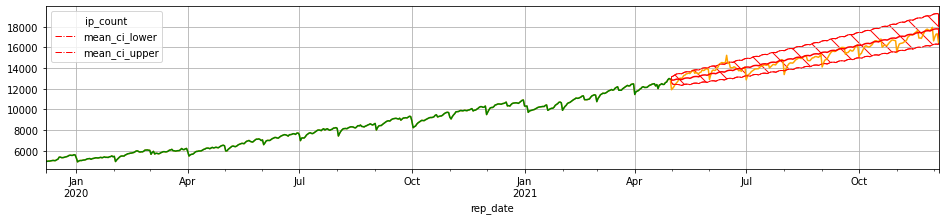

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Medium
billing_account_state: active; billing_account_usage_status: paid; crm_segment: Enterprise


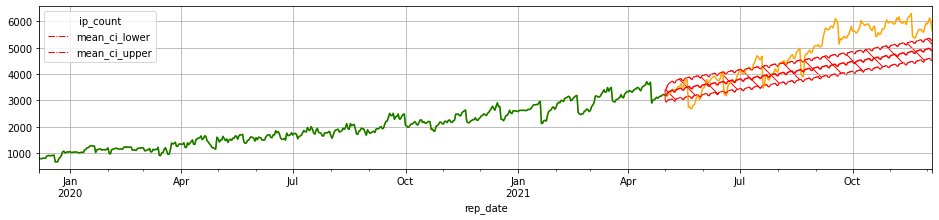

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Public sector
billing_account_state: active; billing_account_usage_status: paid; crm_segment: Cloud Service
billing_account_state: active; billing_account_usage_status: service; crm_segment: Mass


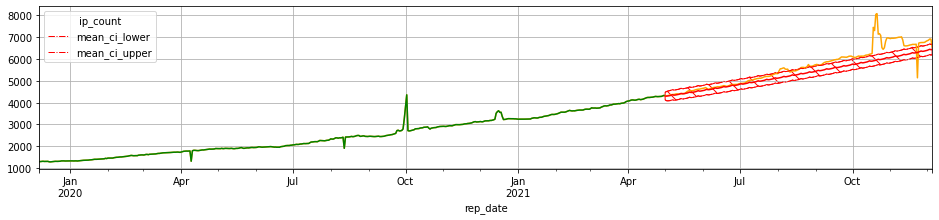

billing_account_state: active; billing_account_usage_status: service; crm_segment: Medium
billing_account_state: active; billing_account_usage_status: service; crm_segment: Enterprise
billing_account_state: active; billing_account_usage_status: service; crm_segment: Public sector
billing_account_state: active; billing_account_usage_status: service; crm_segment: Cloud Service
billing_account_state: active; billing_account_usage_status: trial; crm_segment: Mass


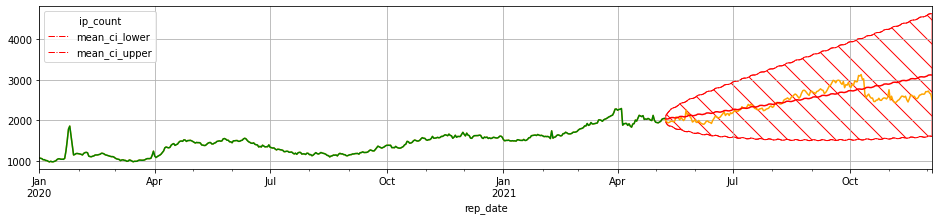

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Medium
billing_account_state: active; billing_account_usage_status: trial; crm_segment: Enterprise
billing_account_state: active; billing_account_usage_status: trial; crm_segment: Public sector
billing_account_state: active; billing_account_usage_status: trial; crm_segment: Cloud Service
billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Mass
billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Medium
billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Enterprise
billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Public sector
billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Cloud Service
billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Mass
billing_account_state: payment_

In [18]:
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    print('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    # figure
    dts_train = all_dts[segment][state][status]['train']
    dts_valid = all_dts[segment][state][status]['valid']
    dts_general = all_dts[segment][state][status]['general']
    bc_lambda = all_dts[segment][state][status]['params']['boxcox']
    future = dts_valid.index[-1]
    model = all_dts[segment][state][status]['best_model']
    dts_pred = model.get_forecast(future).summary_frame()
#     dts_pred = inv_boxcox(dts_pred, bc_lambda)
    

    fig, ax = plt.subplots(figsize=(16,3))
    dts_general['ip_count'].plot(ax=ax, c='orange')
    dts_train['ip_count'].plot(ax=ax, c='green')
    dts_pred['mean'].plot(ax=ax, c='red')
    dts_pred[['mean_ci_lower', 'mean_ci_upper']].plot(ax=ax, c='red', lw=1, ls='-.')
    plt.fill_between(
        dts_pred.index,
        dts_pred['mean_ci_upper'], dts_pred['mean_ci_lower'].fillna(0),
        hatch='\\', color="none", edgecolor='red'
    )
    plt.grid()
    plt.show()
    

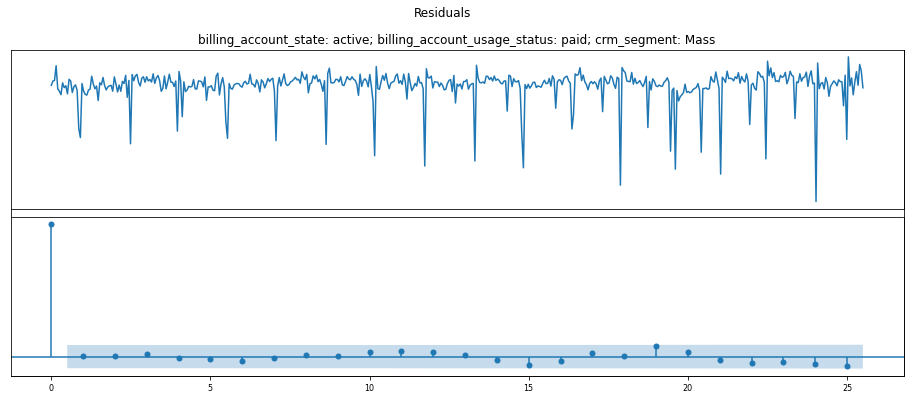

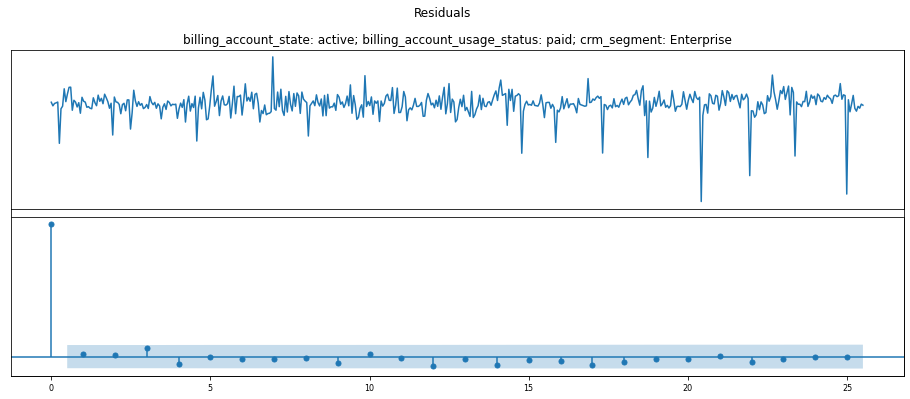

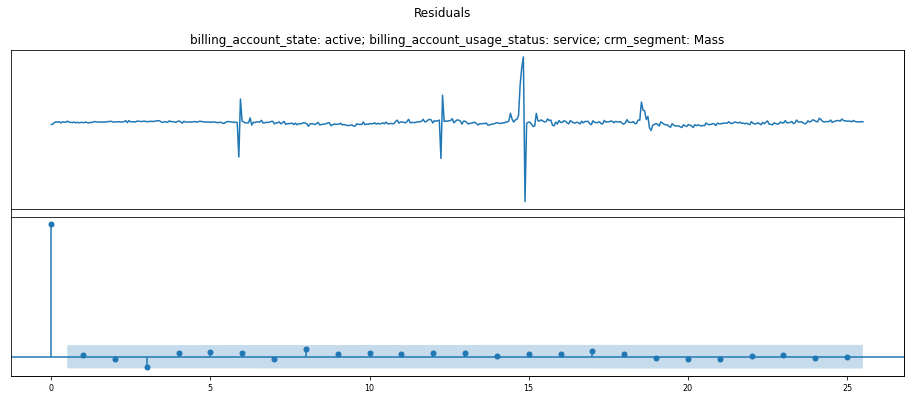

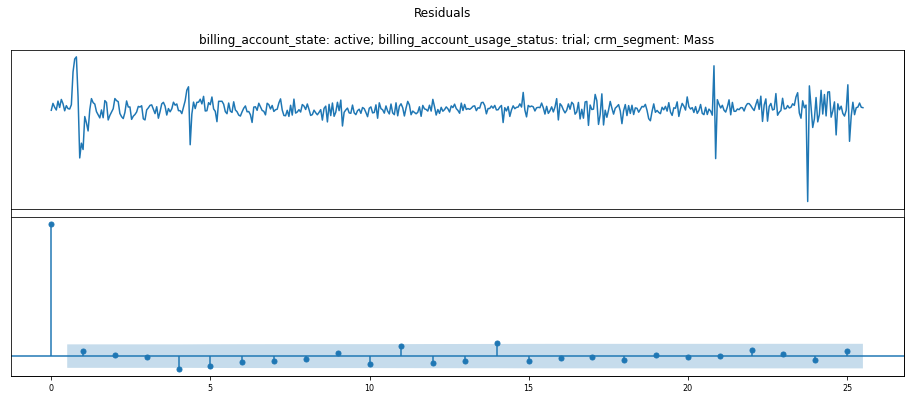

In [19]:
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue

    # figure
    fig = plt.figure(figsize=(16, 6))
    plt.suptitle(f'Residuals')
    outer = gridspec.GridSpec(nrows=1, ncols=1, wspace=0.1, hspace=0.25)
    fig.add_subplot(outer[0])

    dts_temp = all_dts[segment][state][status]['general']
    
    plt.title('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    plt.xticks([])
    plt.yticks([])
    inner = gridspec.GridSpecFromSubplotSpec(
        subplot_spec=outer[0],
        nrows=2, ncols=1,
        wspace=0.05, hspace=0.05
    )
    S = all_dts[segment][state][status]['params']['S']
    residuals = all_dts[segment][state][status]['best_model'].resid[S+1:]

    ax0 = plt.Subplot(fig, inner[0])
    ax0.plot(residuals.index, residuals)
    ax0.set_xticks([])
    ax0.set_yticks([])
    fig.add_subplot(ax0)
    ax1 = plt.Subplot(fig, inner[1])
    sm.graphics.tsa.plot_acf(residuals.values, lags=25, ax=ax1)
    ax1.set_title('')
    ax1.set_yticks([])
    ax1.tick_params(axis='x', labelsize=8)
    fig.add_subplot(ax1)
    plt.show()
    

### Saving params

In [20]:
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    date_from = fip4_config[segment][state][status]['date_from']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1) or (graph_type != 'advanced'):
        continue
        
    
    params = {}
    params['boxcox'] = all_dts[segment][state][status]['params']['boxcox']
    params['p'] = all_dts[segment][state][status]['params']['p']
    params['d'] = all_dts[segment][state][status]['params']['d']
    params['q'] = all_dts[segment][state][status]['params']['q']
    params['P'] = all_dts[segment][state][status]['params']['P']
    params['D'] = all_dts[segment][state][status]['params']['D']
    params['Q'] = all_dts[segment][state][status]['params']['Q']
    params['S'] = all_dts[segment][state][status]['params']['S']
    params['trend'] = all_dts[segment][state][status]['params']['trend']
    
    fip4_config[segment][state][status]['params'] = params


In [21]:
with open('../src/resources_overbooking/fip4/config/params_fip4.py', 'w', encoding="utf-8") as fp:
    fp.write(f'trained_params = {json.dumps(fip4_config, sort_keys=True, indent=4, ensure_ascii=False)}\n')

## Forecast for all cases

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Mass
advanced


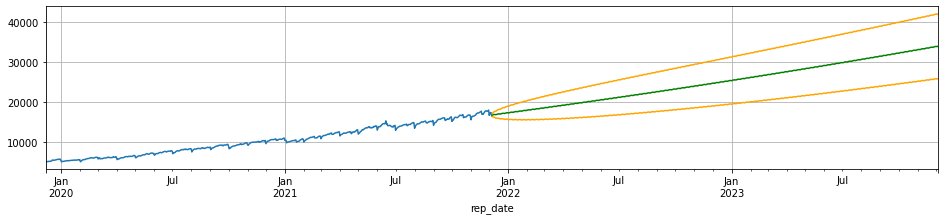

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Medium
simple


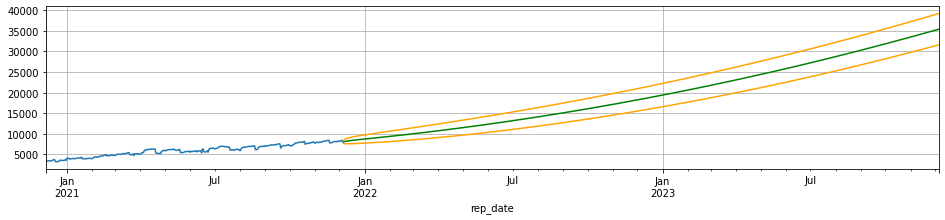

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Enterprise
advanced


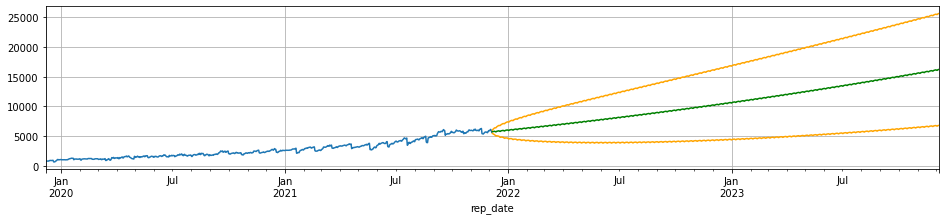

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Public sector
simple


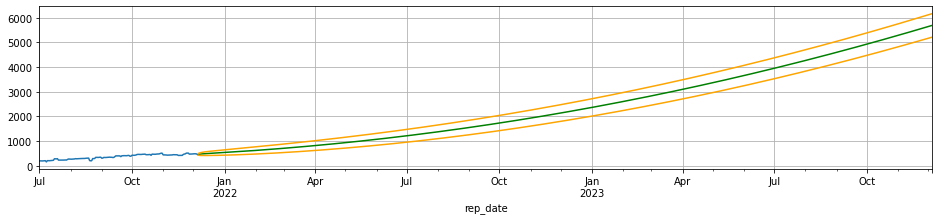

billing_account_state: active; billing_account_usage_status: paid; crm_segment: Cloud Service
const IGNORED

billing_account_state: active; billing_account_usage_status: service; crm_segment: Mass
advanced


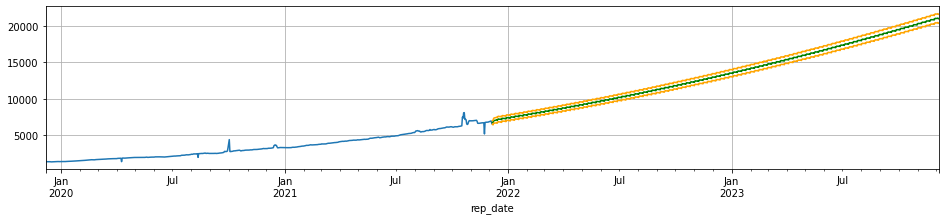

billing_account_state: active; billing_account_usage_status: service; crm_segment: Medium
const IGNORED

billing_account_state: active; billing_account_usage_status: service; crm_segment: Enterprise
const IGNORED

billing_account_state: active; billing_account_usage_status: service; crm_segment: Public sector
const IGNORED

billing_account_state: active; billing_account_usage_status: service; crm_segment: Cloud Service
const


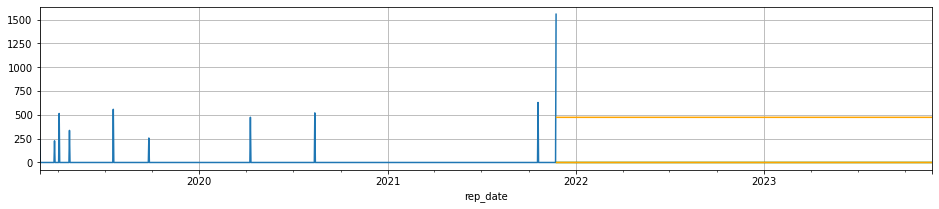

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Mass
advanced


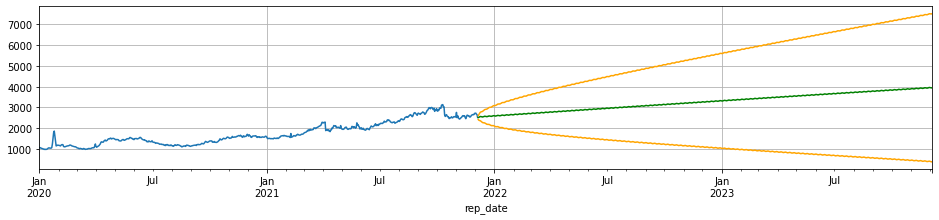

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Medium
const


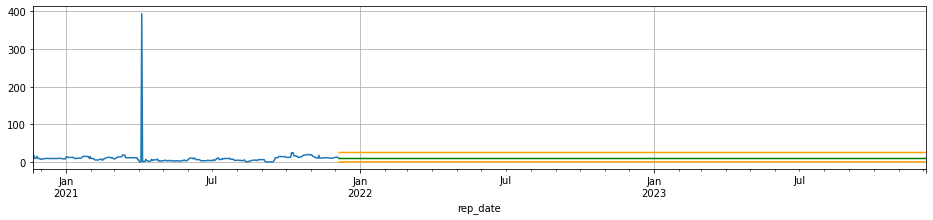

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Enterprise
simple


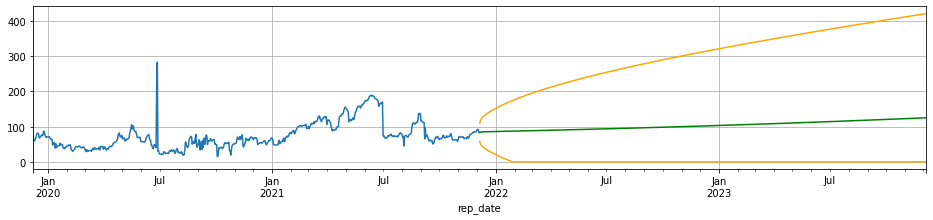

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Public sector
const


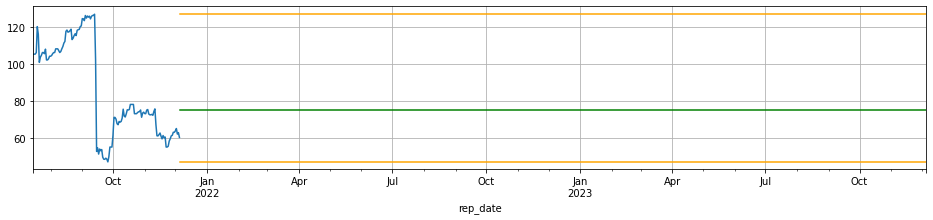

billing_account_state: active; billing_account_usage_status: trial; crm_segment: Cloud Service
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Mass
const


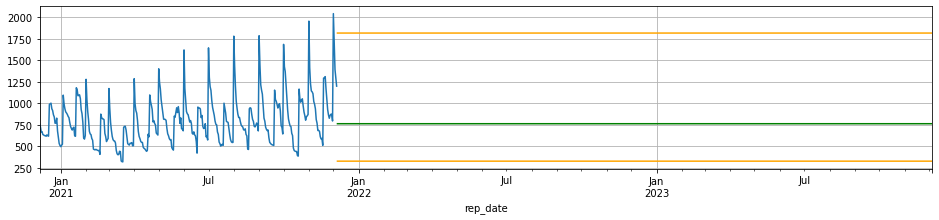

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Medium
simple


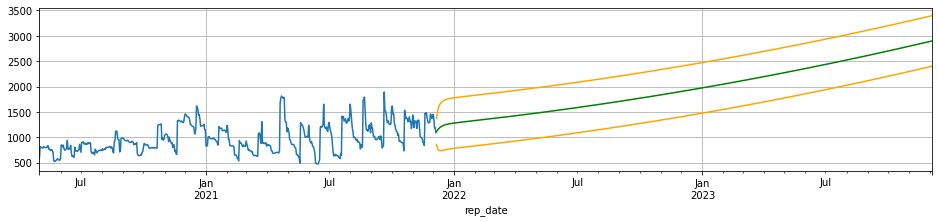

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Enterprise
simple


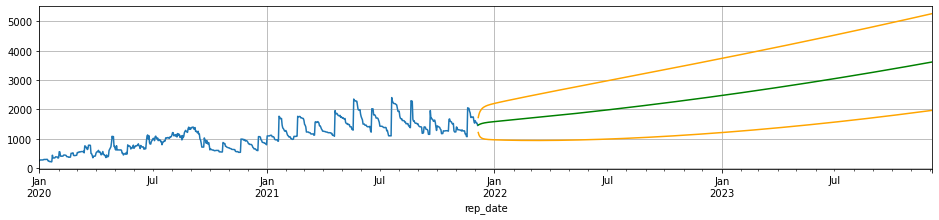

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Public sector
const


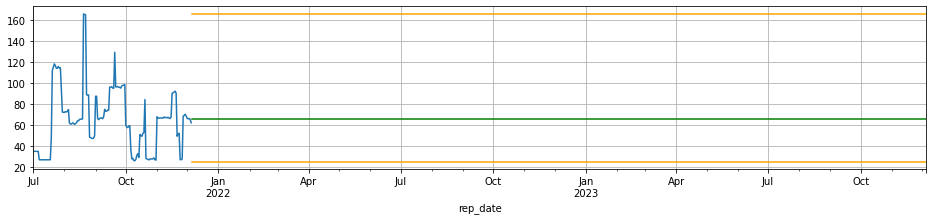

billing_account_state: payment_required; billing_account_usage_status: paid; crm_segment: Cloud Service
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Mass
const


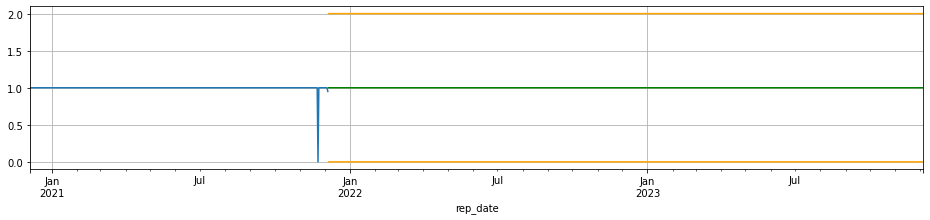

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Medium
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Enterprise
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Public sector
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: service; crm_segment: Cloud Service
const


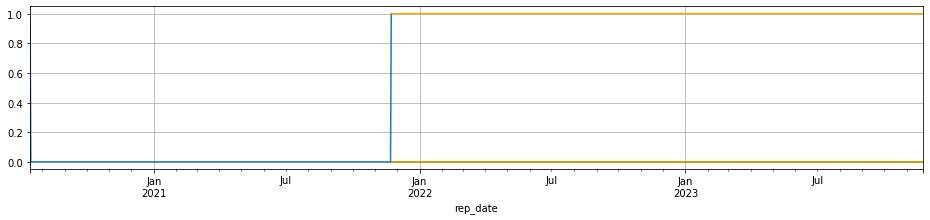

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Mass
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Medium
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Enterprise
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Public sector
const IGNORED

billing_account_state: payment_required; billing_account_usage_status: trial; crm_segment: Cloud Service
const IGNORED

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Mass
const


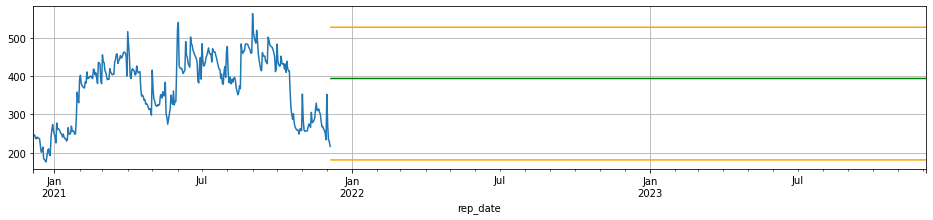

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Medium
const


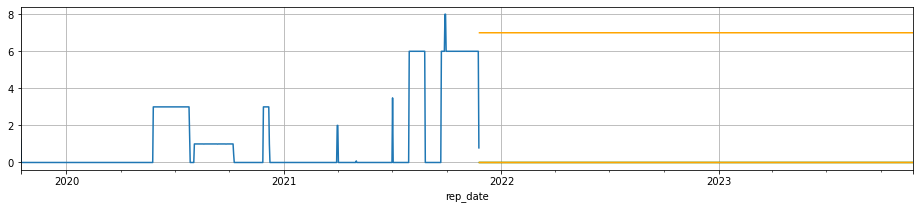

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Enterprise
const


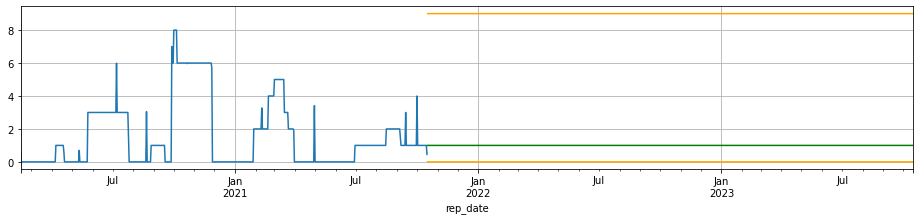

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Public sector
const


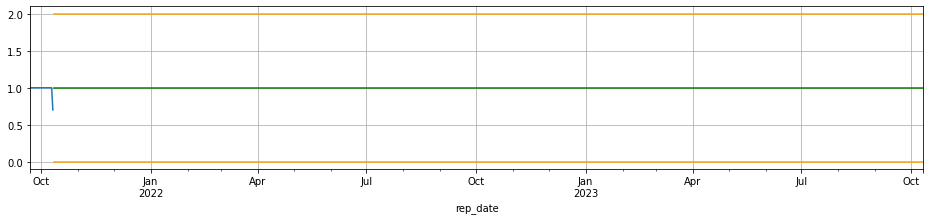

billing_account_state: suspended; billing_account_usage_status: paid; crm_segment: Cloud Service
const IGNORED

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Mass
const


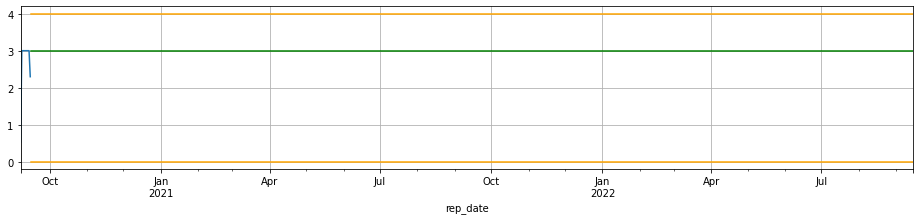

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Medium
const IGNORED

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Enterprise
const IGNORED

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Public sector
const IGNORED

billing_account_state: suspended; billing_account_usage_status: service; crm_segment: Cloud Service
const IGNORED

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Mass
const


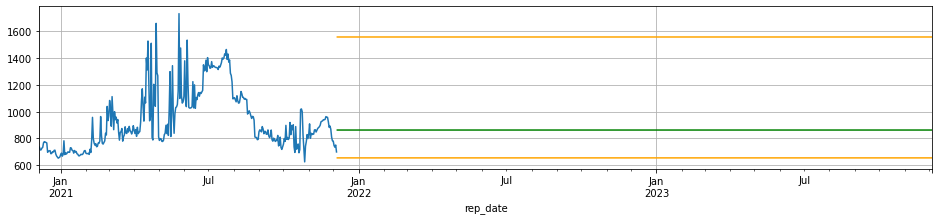

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Medium
const


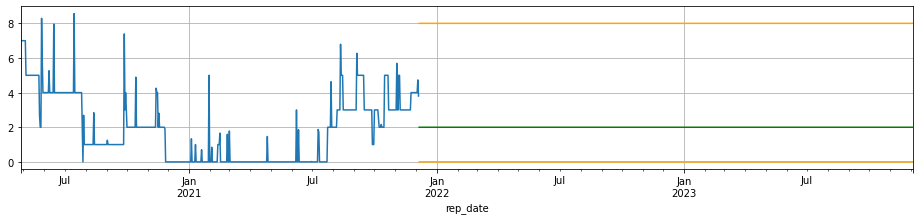

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Enterprise
const


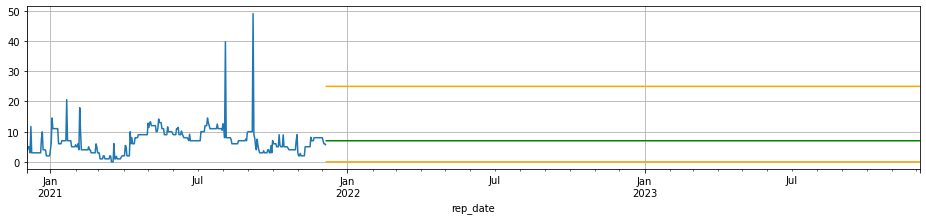

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Public sector
const


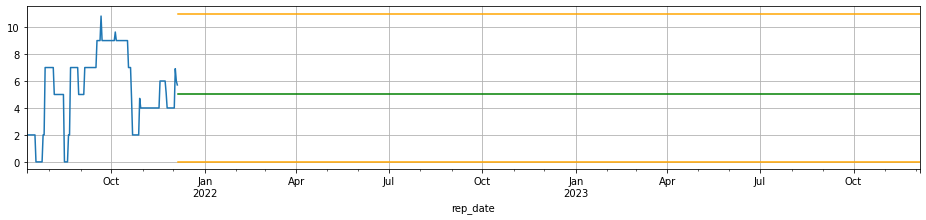

billing_account_state: suspended; billing_account_usage_status: trial; crm_segment: Cloud Service
const IGNORED



In [22]:
def predict_fip4_ts(df, cfg):
    # define params
    p_val = 0.01
    state = df['billing_account_state'].dropna().iloc[0]
    status = df['billing_account_usage_status'].dropna().iloc[0]
    segment = df['crm_segment'].dropna().iloc[0]
    calc_date = df['calc_date'].dropna().iloc[0]
    predict_params = cfg[segment][state][status]
    f_days = predict_params['forecast_days']
    h_days = predict_params['history_days']
    if predict_params['date_from'] == '':
        dt_from = df['rep_date'].min()
    else:
        dt_from = predict_params['date_from']

    # make normal timeseries
    ts_df = df[df['rep_date']>=dt_from].sort_values(by='rep_date')
    new_index = pd.to_datetime(ts_df['rep_date'])
    ts_df = ts_df.set_index(new_index.values)
    ts = ts_df['ip_count'].iloc[-h_days:]

    # prediction date borders
    dt_fmt = '%Y-%m-%d'
    from_date = datetime.strptime(df['rep_date'].max(), dt_fmt) + timedelta(days=1)
    to_date = datetime.strptime(df['rep_date'].max(), dt_fmt) + timedelta(days=f_days)

    # predict const graph
    if predict_params['forecast_type'] == 'const':
        ts = ts.resample('D').max().fillna(0)
        mean = int(round(ts.median()))
        mean_se = round(ts.std(), 2)
        mean_ci_lower = max(int(round(ts.quantile(q=p_val*0.5)-1)), 0)
        mean_ci_upper = int(round(ts.quantile(q=1-p_val*0.5)+1))

        df_pred = pd.DataFrame(index=pd.date_range(from_date, to_date))
        df_pred['mean'] = mean
        df_pred['mean_se'] = mean_se
        df_pred['mean_ci_lower'] = mean_ci_lower
        df_pred['mean_ci_upper'] = mean_ci_upper
        result_df = pd.concat([ts.rename('ip_count'), df_pred], axis=1)

    # forward fill ts for stasmodels library
    ts = ts.resample('D').max().ffill()
    
    # predict simple graph
    if predict_params['forecast_type'] == 'simple':
        simple_model = sm.tsa.SARIMAX(ts, order=(1, 1, 1), trend='t').fit(maxiter=200)
        try:
            df_pred = simple_model.get_forecast(to_date).summary_frame().clip(lower=0)
            df_pred['rep_date'] = df_pred.index.strftime(dt_fmt)
            result_df = pd.concat([ts.rename('ip_count'), df_pred], axis=1)
        except Exception:
            result_df = pd.DataFrame(ts.rename('ip_count'))
            result_df['mean'] = np.nan
            result_df['mean_se'] = np.nan
            result_df['mean_ci_lower'] = np.nan
            result_df['mean_ci_upper'] = np.nan
        result_df['rep_date'] = result_df.index.strftime(dt_fmt)
    
    if predict_params['forecast_type'] == 'advanced':
        adv_params = predict_params['params']
        par_bc = adv_params['boxcox']
        par_tr = adv_params['trend']
        par_p = adv_params['p']
        par_d = adv_params['d']
        par_q = adv_params['q']
        par_P = adv_params['P']
        par_D = adv_params['D']
        par_Q = adv_params['Q']
        par_S = adv_params['S']
        
        ts_mod = ts #  pd.Series(stats.boxcox(ts, lmbda=par_bc), index=ts.index)
        adv_model = sm.tsa.SARIMAX(
            ts_mod,
            order=(par_p, par_d, par_q),
            seasonal_order=(par_P, par_D, par_Q, par_S),
            trend=par_tr).fit(maxiter=200)
        try:
            df_pred_mod = adv_model.get_forecast(to_date).summary_frame().clip(lower=0)
            df_pred = df_pred_mod #  inv_boxcox(df_pred_mod, par_bc).clip(upper=ts.max()*10)
            df_pred['rep_date'] = df_pred.index.strftime(dt_fmt)
            result_df = pd.concat([ts.rename('ip_count'), df_pred], axis=1)
        except Exception as exc:
            print(exc)
            result_df = pd.DataFrame(ts.rename('ip_count'))
            result_df['mean'] = np.nan
            result_df['mean_se'] = np.nan
            result_df['mean_ci_lower'] = np.nan
            result_df['mean_ci_upper'] = np.nan
        result_df['rep_date'] = result_df.index.strftime(dt_fmt)

    result_df['rep_date'] = result_df.index.strftime(dt_fmt)
    result_df = result_df.reset_index(drop=True)
    result_df['calc_date'] = calc_date
    result_df['billing_account_state'] = state
    result_df['billing_account_usage_status'] = status
    result_df['crm_segment'] = segment
        
    return result_df

# simple and const forecasts at all possible timeseries combinations
for item in filter_iterator:
    tmp_df = df.copy()
    for col, col_val in zip(filter_cols, item):
        tmp_df = tmp_df[tmp_df[col] == col_val]
    print('; '.join([f'{col}: {col_val}' for col, col_val in zip(filter_cols, item)]))
    
    # extract timeseries params
    state = item[0]
    status = item[1]
    segment = item[2]
    graph_type = fip4_config[segment][state][status]['forecast_type']
    
    # ignore graph and config if there is no timeseries
    if (tmp_df.shape[0] < 1):
        print(graph_type, 'IGNORED\n')
        continue
    
    print(graph_type)

    tmp_df = predict_fip4_ts(tmp_df, fip4_config)
    
    # figure
    fig, ax = plt.subplots(figsize=(16,3))
    tmp_df = tmp_df.sort_values('rep_date')
    tmp_df['rep_date'] = pd.to_datetime(tmp_df['rep_date'])
    tmp_df = tmp_df.set_index('rep_date')
    tmp_df['ip_count'].plot(ax=ax)
    tmp_df['mean'].plot(ax=ax, c='green')
    tmp_df['mean_ci_lower'].plot(ax=ax, c='orange')
    tmp_df['mean_ci_upper'].plot(ax=ax, c='orange')
    plt.grid()
    plt.xlim(tmp_df.index.min(), tmp_df.index.max())
    plt.show()